In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

df = pd.read_csv('../data/old/data.csv')

In [3]:
cols = [
    "close_ma_30", 
    "close_ma_90", 
    "close_ma_200", 
    "volume_ma_30", 
    "volume_ma_90", 
    "volume_ma_200", 
    "currentRatio_ma", 
    "quickRatio_ma", 
    "returnOnEquity_ma", 
    "returnOnAssets_ma", 
    "netProfitMargin_ma", 
    "priceEarningsRatio_ma", 
    "priceBookValueRatio_ma", 
    "priceToSalesRatio_ma", 
    "freeCashFlowPerShare_ma", 
    "operatingCashFlowPerShare_ma", 
    "cashFlowToDebtRatio_ma", 
    "debtEquityRatio_ma", 
    "longTermDebtToCapitalization_ma", 
    "assetTurnover_ma", 
    "inventoryTurnover_ma"
]


scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[cols]))
df_scaled.columns = cols

# concat scaled colums

df = df.drop(cols, axis=1)
df_scaled = pd.concat([df, df_scaled], axis=1)

In [4]:
df_scaled.to_csv('../data/data_scaled.csv', index=False)

In [5]:
# log transform everything

cols = list(df_scaled.columns)
cols.pop(0)

df_scaled.fillna(method='ffill', inplace=True)
df_log = np.log1p(df_scaled[cols] + 1e-6)
df_log.fillna(method='ffill', inplace=True)
df_log['symbol'] = df_scaled['symbol']

/var/folders/sz/y6mbyrnd7d1g13bfc3t_0q5c0000gn/T/ipykernel_45265/1550689925.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_scaled.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/var/folders/sz/y6mbyrnd7d1g13bfc3t_0q5c0000gn/T/ipykernel_45265/1550689925.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_log.fillna(method='ffill', inplace=True)


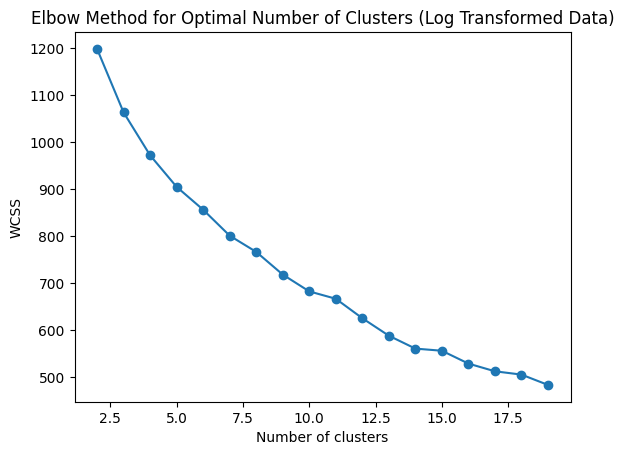

In [6]:
wcss_log = []
range_n_clusters = list(range(2, 20))

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(df_log[cols])
    wcss_log.append(kmeans.inertia_)

plt.plot(range_n_clusters, wcss_log, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters (Log Transformed Data)')
plt.show()

In [32]:
# test for 6 clusters

kmeans_6 = KMeans(n_clusters=8, random_state=42, n_init=10)
df_log['cluster_6'] = kmeans_6.fit_predict(df_log[cols])

clusters_by_symbol_6 = df_log[['symbol', 'cluster_6']]
clusters_by_symbol_6

,symbol,cluster_6
0,APO,0
1,LII,7
2,WDAY,5
3,TPL,2
4,DELL,6
...,...,...
495,PPG,7
496,RTX,0
497,SLB,0
498,SO,0


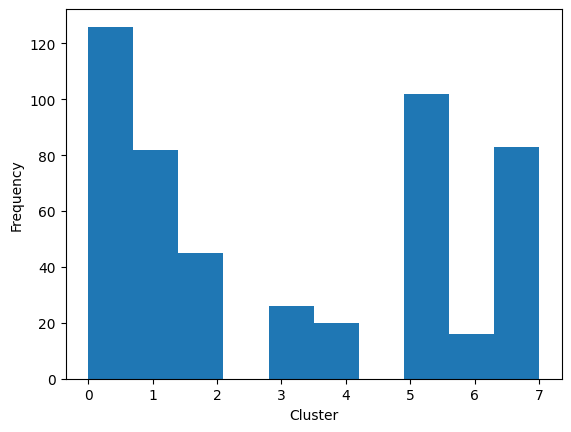

In [33]:
plt.hist(df_log['cluster_6'])
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

In [34]:
clusters_by_symbol_6.to_csv('../data/k6ml2.csv', index=False)

In [35]:
df_log['cluster_6'].value_counts()

cluster_6
0    126
5    102
7     83
1     82
2     45
3     26
4     20
6     16
Name: count, dtype: int64

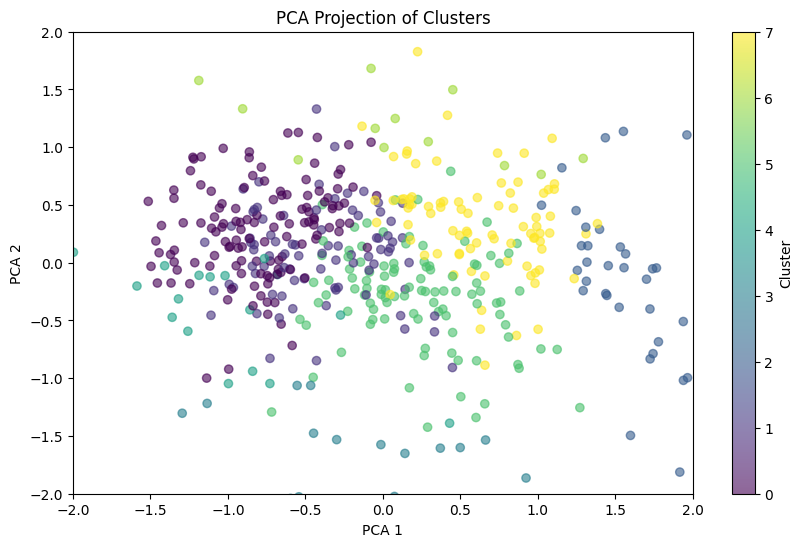

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
df_log['pca_1'], df_log['pca_2'] = zip(*pca.fit_transform(df_log[cols]))

plt.figure(figsize=(10,6))
plt.scatter(df_log['pca_1'], df_log['pca_2'], c=df_log['cluster_6'], cmap='viridis', alpha=0.6)
plt.xlabel("PCA 1")
plt.xlim(-2, 2)
plt.ylabel("PCA 2")
plt.ylim(-2, 2)
plt.title("PCA Projection of Clusters")
plt.colorbar(label="Cluster")
plt.show()

In [30]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, random_state=42)
df_log['gmm'] = gmm.fit_predict(df_log[cols])

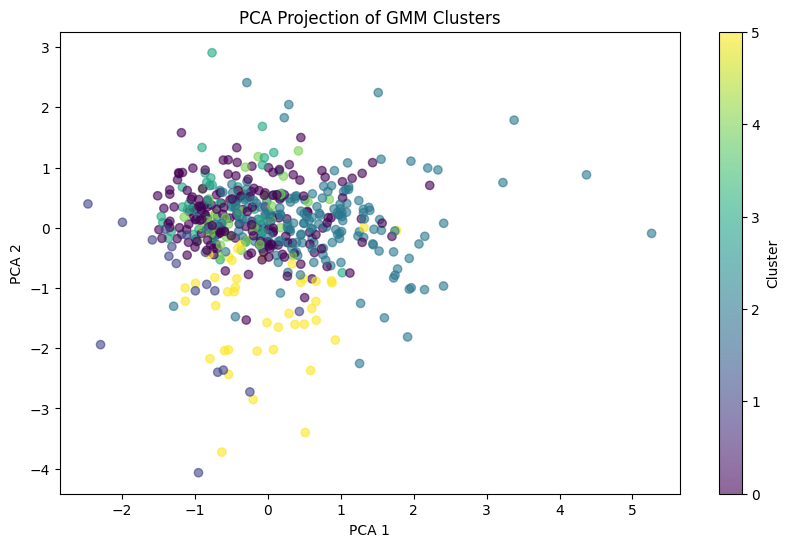

In [31]:
pca = PCA(n_components=2)
df_log['pca_1'], df_log['pca_2'] = zip(*pca.fit_transform(df_log[cols]))

plt.figure(figsize=(10,6))
plt.scatter(df_log['pca_1'], df_log['pca_2'], c=df_log['gmm'], cmap='viridis', alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection of GMM Clusters")
plt.colorbar(label="Cluster")
plt.show()
